In [1]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# basic tools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [26]:
PATH = '/home/disk/orca/adaley17/MLGEO2024_TC_Tracks_Intensity/data/'
bt_data = 'clean/cleaned_best_track_data.csv'
ships_data = 'ai_ready/ai_ready_SHIPS_data.csv'
PNG = '/home/disk/orca/adaley17/MLGEO2024_TC_Tracks_Intensity/figures/'

df_SHIPS = pd.read_csv(os.path.join(PATH, ships_data))
df_BT = pd.read_csv(os.path.join(PATH, bt_data))

In [3]:
df_SHIPS


,Original_Times,Code,Times,Daily_SST_Avg,Mid_Level_RH,Vert_Vel,Vshear,MSLP,Vmax,Latitude,Longitude
0,1982-06-02 12:00:00,AL011982,-12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1982-06-02 12:00:00,AL011982,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1982-06-02 12:00:00,AL011982,0.0,27.1,57.0,6.631183,15.227542,1005.0,10.28888,21.7,87.1
3,1982-06-02 12:00:00,AL011982,6.0,27.8,53.0,3.966363,15.536209,1004.0,12.86110,22.2,86.5
4,1982-06-02 12:00:00,AL011982,12.0,27.9,56.0,4.403641,15.330431,1003.0,15.43332,22.6,85.8
...,...,...,...,...,...,...,...,...,...,...,...
318545,2022-11-11 12:00:00,AL172022,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318546,2022-11-11 12:00:00,AL172022,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318547,2022-11-11 12:00:00,AL172022,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318548,2022-11-11 12:00:00,AL172022,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_BT.head()

,ISO_TIME,USA_ATCF_ID,NAME,DIST2LAND,LANDFALL,STORM_SPEED,STORM_DIR,USA_LAT,USA_LON,USA_WIND,WMO_WIND,WMO_PRES,USA_PRES,USA_RMW,USA_WSPD
0,1982-06-02 12:00:00,AL011982,ALBERTO,22,40744.0,3.601108,47,21.7000,-87.1000,10.288880,10.28888,1005,1005.0,NaN,10.288880
1,1982-06-02 15:00:00,AL011982,ALBERTO,59,109268.0,4.115552,48,21.9551,-86.8077,11.317768,NaN,,1004.0,NaN,11.317768
2,1982-06-02 18:00:00,AL011982,ALBERTO,93,172236.0,4.115552,52,22.2000,-86.5000,12.861100,12.86110,1004,1004.0,NaN,12.861100
3,1982-06-02 21:00:00,AL011982,ALBERTO,130,209276.0,4.115552,58,22.4224,-86.1650,13.889988,NaN,,1003.0,NaN,13.889988
4,1982-06-03 00:00:00,AL011982,ALBERTO,113,181496.0,4.115552,68,22.6000,-85.8000,15.433320,15.43332,1003,1003.0,NaN,15.433320


## Cleaning Up Data

### Subsetting the first 30 hours of BT and SHIPS Data

In [5]:
# Subsampling the data so that we only have the first 24 hours of each storm
df_BT_24 = df_BT.groupby('USA_ATCF_ID').head(30) #This will be our Obseravtion data


# Filter the DataFrame for Times from 0 to 24 for each Code
filtered_df = df_SHIPS[(df_SHIPS['Times'] >= 0) & (df_SHIPS['Times'] <= 30)]

# Group by Code and extract the relevant columns
df_SHIPS_24 = filtered_df.groupby('Code').apply(lambda x: x[['Original_Times', 'Code', 'Times', 'Latitude', 'Longitude', 'Vmax', 'MSLP', 'Daily_SST_Avg', 'Mid_Level_RH', 'Vshear', 'Vert_Vel']]).reset_index(drop=True)

# df_SHIPS_24


<ipython-input-5-70ef97ec7642>:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_SHIPS_24 = filtered_df.groupby('Code').apply(lambda x: x[['Original_Times', 'Code', 'Times', 'Latitude', 'Longitude', 'Vmax', 'MSLP', 'Daily_SST_Avg', 'Mid_Level_RH', 'Vshear', 'Vert_Vel']]).reset_index(drop=True)


### Identifying common codes across datasets

In [6]:
# Set 'Code' as an index level in df_SHIPS_24
df_SHIPS_24 = df_SHIPS_24.set_index('Code')

# Extract the unique IDs from both dataframes
bt_ids = df_BT_24['USA_ATCF_ID'].unique()
ships_ids = df_SHIPS_24.index.get_level_values('Code').unique()

# Find common IDs
common_ids = np.intersect1d(bt_ids, ships_ids)

# Find IDs only in df_BT_24
bt_only_ids = np.setdiff1d(bt_ids, ships_ids)

# Find IDs only in df_SHIPS_24
ships_only_ids = np.setdiff1d(ships_ids, bt_ids)

print(f"Common IDs: {len(common_ids)}")
print(f"IDs only in df_BT_24: {len(bt_only_ids)}")
print(f"IDs only in df_SHIPS_24: {len(ships_only_ids)}")



Common IDs: 539
IDs only in df_BT_24: 23
IDs only in df_SHIPS_24: 71


### Keeping Common IDs

In [7]:
# Filter df_BT_24 to keep only common IDs
df_BT_24_common = df_BT_24[df_BT_24['USA_ATCF_ID'].isin(common_ids)]

# Filter df_SHIPS_24 to keep only common IDs
df_SHIPS_24_common = df_SHIPS_24[df_SHIPS_24.index.get_level_values('Code').isin(common_ids)]

# Check if the lengths of the filtered dataframes are the same
print(f"Length of df_BT_24_common: {len(df_BT_24_common)}")
print(f"Length of df_SHIPS_24_common: {len(df_SHIPS_24_common)}")

Length of df_BT_24_common: 15287
Length of df_SHIPS_24_common: 79440


### Matching Times

In [8]:
new_times = [None] * len(df_SHIPS_24_common['Original_Times']) #Empty list to store the new times
for i in range(len(df_SHIPS_24_common['Original_Times'])):
    
    original_time = pd.to_datetime(df_SHIPS_24_common['Original_Times'].iloc[i]) #Time when prediction was made

    # print(original_time, original_time + pd.Timedelta(hours=df_SHIPS_24_common['Times'].iloc[i]))
    new_times[i] = original_time + pd.Timedelta(hours=df_SHIPS_24_common['Times'].iloc[i]) #Add the time of prediction to the time when prediction was made

    
df_SHIPS_24_common.loc[:, 'New_Times'] = new_times #Add the new times to the DataFrame
df_SHIPS_24_common.head()

<ipython-input-8-a5379391ebe0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SHIPS_24_common.loc[:, 'New_Times'] = new_times #Add the new times to the DataFrame


,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times
Code,,,,,,,,,,,
AL011982,1982-06-02 12:00:00,0.0,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,1982-06-02 12:00:00
AL011982,1982-06-02 12:00:00,6.0,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,1982-06-02 18:00:00
AL011982,1982-06-02 12:00:00,12.0,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,1982-06-03 00:00:00
AL011982,1982-06-02 12:00:00,18.0,22.8,85.0,20.57776,1001.0,27.2,59.0,18.622873,5.375940,1982-06-03 06:00:00
AL011982,1982-06-02 12:00:00,24.0,23.2,84.2,25.72220,995.0,26.7,53.0,17.491096,4.156708,1982-06-03 12:00:00


In [9]:
df_SHIPS_24_common

# Convert ISO_TIME to datetime format
df_BT_24_common['ISO_TIME'] = pd.to_datetime(df_BT_24_common['ISO_TIME'])

# df_merged = pd.merge(df_SHIPS_24_common.reset_index(), 
# df_BT_24_common[['ISO_TIME', 'USA_ATCF_ID', 'USA_WSPD', 'USA_PRES', 
#                     'WMO_WIND', 'USA_WIND', 'STORM_DIR', 'WMO_PRES']], 
#             how='inner')

<ipython-input-9-7888a354acea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BT_24_common['ISO_TIME'] = pd.to_datetime(df_BT_24_common['ISO_TIME'])


In [10]:
# Remove rows with NaNs in the Vmax column
df_SHIPS_24_common_clean = df_SHIPS_24_common.dropna(subset=['Vmax'])

# Display the cleaned DataFrame
df_SHIPS_24_common_clean.head()

,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times
Code,,,,,,,,,,,
AL011982,1982-06-02 12:00:00,0.0,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,1982-06-02 12:00:00
AL011982,1982-06-02 12:00:00,6.0,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,1982-06-02 18:00:00
AL011982,1982-06-02 12:00:00,12.0,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,1982-06-03 00:00:00
AL011982,1982-06-02 12:00:00,18.0,22.8,85.0,20.57776,1001.0,27.2,59.0,18.622873,5.375940,1982-06-03 06:00:00
AL011982,1982-06-02 12:00:00,24.0,23.2,84.2,25.72220,995.0,26.7,53.0,17.491096,4.156708,1982-06-03 12:00:00


# Intensity Model

In [12]:
df_intensity = df_SHIPS_24_common_clean.copy()
df_intensity.head()

,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times
Code,,,,,,,,,,,
AL011982,1982-06-02 12:00:00,0.0,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,1982-06-02 12:00:00
AL011982,1982-06-02 12:00:00,6.0,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,1982-06-02 18:00:00
AL011982,1982-06-02 12:00:00,12.0,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,1982-06-03 00:00:00
AL011982,1982-06-02 12:00:00,18.0,22.8,85.0,20.57776,1001.0,27.2,59.0,18.622873,5.375940,1982-06-03 06:00:00
AL011982,1982-06-02 12:00:00,24.0,23.2,84.2,25.72220,995.0,26.7,53.0,17.491096,4.156708,1982-06-03 12:00:00


## Encoding the Codes assigned to each storm

Each storm is assigned a code based on the basin where it occurs, name and year when it happened. The code is represented as a string

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


df_intensity_clean = df_intensity.reset_index()
df_intensity_clean['Code'] = LabelEncoder().fit(df_intensity_clean['Code']).transform(df_intensity_clean['Code']) # Extract the TC_codes
df_intensity_clean.head()

,Code,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times
0,0,1982-06-02 12:00:00,0.0,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,1982-06-02 12:00:00
1,0,1982-06-02 12:00:00,6.0,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,1982-06-02 18:00:00
2,0,1982-06-02 12:00:00,12.0,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,1982-06-03 00:00:00
3,0,1982-06-02 12:00:00,18.0,22.8,85.0,20.57776,1001.0,27.2,59.0,18.622873,5.375940,1982-06-03 06:00:00
4,0,1982-06-02 12:00:00,24.0,23.2,84.2,25.72220,995.0,26.7,53.0,17.491096,4.156708,1982-06-03 12:00:00


## Adding storm direction to the dataframe

In [15]:
# Merge df_intensity_clean with df_BT_24_common on the respective times
df_intensity_clean = pd.merge(df_intensity_clean, df_BT_24_common[['ISO_TIME', 'STORM_DIR']], left_on='New_Times', right_on='ISO_TIME', how='left')

# Rename the STORM_DIR column to Storm_Dir
df_intensity_clean.rename(columns={'STORM_DIR': 'Storm_Dir'}, inplace=True)

# Drop the ISO_TIME column as it is no longer needed
df_intensity_clean.drop(columns=['ISO_TIME'], inplace=True)

#Removing Nan values
df_intensity_clean = df_intensity_clean.dropna()
df_intensity_clean.shape

# Display the updated dataframe
df_intensity_clean.tail()

,Code,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times,Storm_Dir
83279,485,2022-11-09 06:00:00,6.0,26.5,76.2,28.29442,985.0,28.0,48.0,17.336763,6.281361,2022-11-09 12:00:00,262.0
83280,485,2022-11-09 06:00:00,12.0,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,2022-11-09 18:00:00,270.0
83284,485,2022-11-09 12:00:00,0.0,26.5,76.2,28.29442,985.0,28.0,48.0,17.336763,6.281361,2022-11-09 12:00:00,262.0
83285,485,2022-11-09 12:00:00,6.0,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,2022-11-09 18:00:00,270.0
83290,485,2022-11-09 18:00:00,0.0,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,2022-11-09 18:00:00,270.0


## Splitting the Data into Training and Test

We perform this split in a manner which maintains the codes across each both data sets

In [16]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets while ensuring the 'Code' column is consistent across the split
train_codes, test_codes = train_test_split(df_intensity_clean['Code'].unique(), test_size=0.2, random_state=42)

# Create training and test sets based on the split codes
train_df = df_intensity_clean[df_intensity_clean['Code'].isin(train_codes)]
test_df = df_intensity_clean[df_intensity_clean['Code'].isin(test_codes)]

# Print the shapes of the resulting DataFrames
print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")

train_df shape: (42951, 13)
test_df shape: (12455, 13)


In [17]:
train_df.head()

,Code,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times,Storm_Dir
87,59,1982-08-28 12:00:00,0.0,13.7,22.2,15.43332,1008.0,26.6,75.0,11.420657,4.521963,1982-08-28 12:00:00,296.0
88,59,1982-08-28 12:00:00,6.0,13.9,22.7,18.00554,1006.0,26.8,76.0,10.957657,4.203007,1982-08-28 18:00:00,285.0
89,59,1982-08-28 12:00:00,12.0,14.1,23.6,18.00554,1005.0,27.9,75.0,10.854768,4.007519,1982-08-29 00:00:00,285.0
90,59,1982-08-28 12:00:00,18.0,14.5,24.9,20.57776,1003.0,26.4,74.0,11.060546,3.950930,1982-08-29 06:00:00,287.0
91,59,1982-08-28 12:00:00,24.0,14.9,26.3,23.14998,1002.0,26.0,72.0,9.620103,3.333597,1982-08-29 12:00:00,286.0


### Specifying data the Model should use

In [18]:
#Train data
X_train = np.array(train_df.drop(columns=['Vmax', 'Original_Times', 'New_Times'])).astype(float) #Removing Variables
y_train = np.array(train_df['Vmax']).astype(float) #Target Variable
t_train = np.asarray(train_df['New_Times']) #Time Variable

#Test data
X_test = np.array(test_df.drop(columns=['Vmax', 'Original_Times', 'New_Times'])).astype(float) #Removing Variables
y_test = np.array(test_df['Vmax']).astype(float) #Target Variable
t_test = np.asarray(test_df['New_Times']) #Time Variable

### Visualizing the Training and Test Data

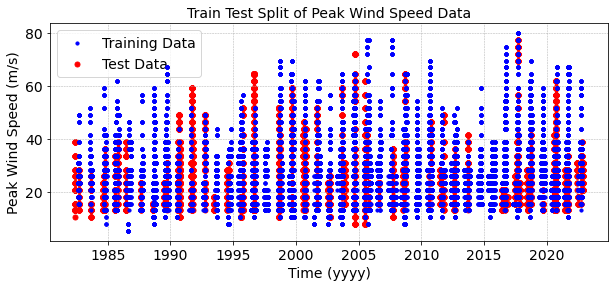

In [51]:
#Figure Settings
fontsize=14

#Plotting the Train Test Split
gridsize = (1, 1)
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1)

#Plotting the data
ax1.scatter(t_train,y_train,marker="o",s=10,c="blue", zorder=100)
ax1.scatter(t_test,y_test,marker="o",s=25,c="red")

#Legend
ax1.legend(['Training Data', 'Test Data'], loc='best', fontsize=fontsize)

#Labels
ax1.set_xlabel('Time (yyyy)', fontsize=fontsize)
ax1.set_ylabel('Peak Wind Speed (m/s)', fontsize=fontsize)
ax1.set_title('Train Test Split of Peak Wind Speed Data', fontsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize)

#Grid
ax1.grid(True, linestyle='--', linewidth=0.5)

#Save the figure
plt.savefig(PNG + 'train_test_split_intensity_model.png', dpi=300, bbox_inches='tight')

plt.show()

## Training and Testing the Model

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
regr = ExtraTreesRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_int = grid_search.best_params_
print("Best parameters found: ", best_params_int)

# Train the model with the best parameters
best_regr = ExtraTreesRegressor(**best_params_int)
best_regr.fit(X_train, y_train)

# Predict and evaluate on the training data
y_train_pred = best_regr.predict(X_train)
y_test_pred = best_regr.predict(X_test)

# Print the evaluation metrics
print('Training set: Coefficient of determination (R^2): ', best_regr.score(X_train, y_train))
print('MSE (mean square error) on training set: %.2f' % mean_squared_error(y_train, y_train_pred))
print('Coefficient of determination on training set: %.2f' % r2_score(y_train, y_train_pred))

print('Test set: Coefficient of determination (R^2): ', best_regr.score(X_test, y_test))
print('MSE (mean square error) on test set: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Coefficient of determination on test set: %.2f' % r2_score(y_test, y_test_pred))

/home/disk/orca/adaley17/anaconda3/envs/geo_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/disk/orca/adaley17/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters found:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


/home/disk/orca/adaley17/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Training set: Coefficient of determination (R^2):  0.9991072506617171
MSE (mean square error) on training set: 0.14
Coefficient of determination on training set: 1.00
Test set: Coefficient of determination (R^2):  0.9170122771654299
MSE (mean square error) on test set: 11.82
Coefficient of determination on test set: 0.92


```markdown
| Metric                                      | Training Set | Test Set |
|---------------------------------------------|--------------|----------|
| Coefficient of determination (R^2)          | 0.9991       | 0.9170   |
| Mean Square Error (MSE)                     | 0.14         | 11.82    |
| Coefficient of determination (R^2) (rounded)| 1.00         | 0.92     |
```
The results training is almost perfect with a very small MSE, however, the test set shows an increase in the $R^2$ and MSE. We still need to viualize the results to ensure it is doing what we expect. Also we need to perform a cross validation.

### Visualize the Results

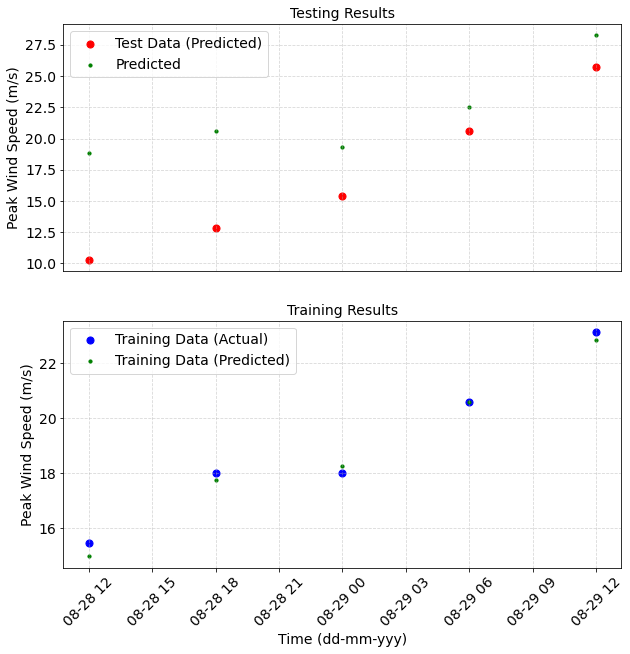

In [52]:
#Figure Settings
fontsize=14

gridsize = (2, 1)
fig = plt.figure(figsize=(10,10))

#Test Data
ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1)

#Plotting the data
ax1.scatter(t_test[0:5],y_test[0:5],marker="o",s=50,c="red")
ax1.scatter(t_test[0:5],y_test_pred[0:5],marker="o",s=10,c="green")

#Legend
ax1.legend(['Test Data (Predicted)', 'Predicted'], loc='best', fontsize=fontsize)

#Labels
# ax1.set_xlabel('Time (dd-mm-yyy)', fontsize=fontsize)
ax1.set_ylabel('Peak Wind Speed (m/s)', fontsize=fontsize)
ax1.set_title('Testing Results', fontsize=fontsize)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', labelsize=fontsize)
ax1.grid(True, linestyle='--', alpha=0.5)

#Train Data
ax2 = plt.subplot2grid(gridsize, (1,0), colspan=1, rowspan=1)

#Plotting the data
ax2.scatter(t_train[0:5], y_train[0:5], marker="o", s=50, c="blue")
ax2.scatter(t_train[0:5], y_train_pred[0:5], marker="o", s=10, c="green")

#Legend
ax2.legend(['Training Data (Actual)', 'Training Data (Predicted)'], loc='upper left', fontsize=fontsize)

#Labels
ax2.set_xlabel('Time (dd-mm-yyy)', fontsize=fontsize)
ax2.set_ylabel('Peak Wind Speed (m/s)', fontsize=fontsize)
ax2.set_title('Training Results', fontsize=fontsize)
ax2.tick_params(axis='x', labelsize=fontsize, rotation=45)
ax2.tick_params(axis='y', labelsize=fontsize)

#Grid
ax2.grid(True, linestyle='--', alpha=0.5)

#Save the figure
plt.savefig(PNG + 'test_and_training_performance_for_one_prediction.png', dpi=300, bbox_inches='tight')

plt.show()

In [55]:
import numpy as np

# Get unique codes from X_test
unique_codes = np.unique(X_test[:, 0])

# Select 10 random codes
random_codes = np.random.choice(unique_codes, 10, replace=False)
print("Random Codes:", random_codes)

Random Codes: [239. 238. 263. 112. 400.  52.  62. 440. 149.  75.]


In [57]:
# Filter the test_df dataframe for the given random_codes
filtered_test_df = test_df[test_df['Code'].isin(random_codes)]

# Extract the corresponding y_test values (Vmax)
corresponding_y_test = filtered_test_df['Vmax'].values
corresponding_t_test = filtered_test_df['New_Times'].values

print("Corresponding y_test values for the given random codes:", corresponding_y_test)
print("Corresponding t_test values for the given random codes:", corresponding_t_test)

Corresponding y_test values for the given random codes: [12.8611  12.8611  12.8611  ... 38.5833  28.29442 28.29442]
Corresponding t_test values for the given random codes: ['1988-08-21T12:00:00.000000000' '1988-08-21T18:00:00.000000000'
 '1988-08-22T00:00:00.000000000' ... '2020-07-26T00:00:00.000000000'
 '2020-07-26T06:00:00.000000000' '2020-07-26T06:00:00.000000000']


In [64]:
# Filter the first and last 5 times for the random codes
first_5_times_random = test_df[test_df['Vmax'].isin(random_codes)].groupby('Vmax').head(5)[['Code', 'New_Times', 'Vmax']]
last_5_times_random = test_df[test_df['Vmax'].isin(random_codes)].groupby('Vmax').tail(5)[['Code', 'New_Times', 'Vmax']]

# Display the results
print("First 5 times predicted for 10 random codes:")
print(first_5_times_random)

print("\nLast 5 times predicted for 10 random codes:")
print(last_5_times_random)

First 5 times predicted for 10 random codes:
Empty DataFrame
Columns: [Code, New_Times, Vmax]
Index: []

Last 5 times predicted for 10 random codes:
Empty DataFrame
Columns: [Code, New_Times, Vmax]
Index: []


In [63]:
test_df.head()

,Code,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times,Storm_Dir
0,0,1982-06-02 12:00:00,0.0,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,1982-06-02 12:00:00,47.0
1,0,1982-06-02 12:00:00,6.0,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,1982-06-02 18:00:00,52.0
2,0,1982-06-02 12:00:00,12.0,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,1982-06-03 00:00:00,68.0
3,0,1982-06-02 12:00:00,18.0,22.8,85.0,20.57776,1001.0,27.2,59.0,18.622873,5.375940,1982-06-03 06:00:00,71.0
4,0,1982-06-02 12:00:00,24.0,23.2,84.2,25.72220,995.0,26.7,53.0,17.491096,4.156708,1982-06-03 12:00:00,47.0


### Cross Validation 

In [48]:
from sklearn.model_selection import cross_val_score

# Use cross-validation to evaluate the model's performance
cv_scores_train = cross_val_score(best_regr, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
cv_scores_test = cross_val_score(best_regr, X_test, y_test, cv=5, scoring='r2', n_jobs=-1)

# Print the cross-validation scores
print("Training Cross-validation scores: ", cv_scores_train)
print("Training Mean cross-validation score: ", cv_scores_train.mean())
print("Test Cross-validation scores: ", cv_scores_test)
print("Test Mean cross-validation score: ", cv_scores_test.mean())

Training Cross-validation scores:  [0.87803844 0.8996507  0.91269101 0.91711912 0.92339743]
Training Mean cross-validation score:  0.9061793413134758
Test Cross-validation scores:  [0.83510559 0.93255986 0.89048555 0.83118627 0.87683506]
Test Mean cross-validation score:  0.873234467620615


**Cross Validation**

Cross-validation is a technique used to evaluate the performance of a machine learning model by partitioning the data into subsets, training the model on some subsets (training set), and validating it on the remaining subsets (test set). This process is repeated multiple times to ensure that the model's performance is consistent and not dependent on a particular split of the data.

```markdown
| Metric                  | Training Set | Test Set |
|-------------------------|--------------|----------|
| Cross Validation        | 0.9062       | 0.8732   |

```

- **Training Set Cross Validation Score (0.9062)**: This indicates that the model performs well on the training data, achieving a high accuracy or performance metric.
- **Test Set Cross Validation Score (0.8732)**: This score is slightly lower than the training set score, which is expected. It shows how well the model generalizes to unseen data.

The difference between the training and test set scores suggests that the model has good generalization capabilities, but there might be a slight overfitting since the training score is higher. However, the difference is not large, indicating that the model is likely well-tuned.



### Bagging

In [49]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

bag_reg_boost = BaggingRegressor(
    base_estimator=ExtraTreesRegressor(**best_params_int), n_estimators=100,  # n_estimators is the number of models to train
    max_samples=1000, bootstrap=True, # bootstrap is for bagging vs pasting
    n_jobs=-1, # number of CPU cores independently used for training and prediction. Use -1 for all available cores
    )
bag_reg_boost.fit(X_train, y_train)
scores_bagg_train = cross_val_score(bag_reg_boost, X_train, y_train, cv=5)
scores_bagg_test = cross_val_score(bag_reg_boost, X_test, y_test, cv=5)
print('Training with Boostrap mean accuracy', scores_bagg_train.mean())
print('Test with Boostrap mean accuracy', scores_bagg_test.mean())

Training with Boostrap mean accuracy 0.9049742833245764
Test with Boostrap mean accuracy 0.8813047572011495


### Pasting

In [50]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

bag_reg_past = BaggingRegressor(
    base_estimator=ExtraTreesRegressor(**best_params_int), n_estimators=100,  # n_estimators is the number of models to train
    max_samples=1000, bootstrap=False, # bootstrap is for bagging vs pasting
    n_jobs=-1, # number of CPU cores independently used for training and prediction. Use -1 for all available cores
    )
bag_reg_past.fit(X_train, y_train)
scores_past_train = cross_val_score(bag_reg_boost, X_train, y_train, cv=5)
scores_past_test = cross_val_score(bag_reg_boost, X_test, y_test, cv=5)
print('Training without Boostrap mean accuracy', scores_past_train.mean())
print('Test without Boostrap mean accuracy', scores_past_test.mean())

Training without Boostrap mean accuracy 0.9051203698585166
Test without Boostrap mean accuracy 0.8807877058110248



Bootstrapping is a statistical method that involves repeatedly sampling with replacement from a dataset to estimate the distribution of a statistic. It is often used to improve the robustness and accuracy of models by providing a way to estimate the variability of the model's performance.

In the provided results:

```markdown
| Method                | Training Mean Accuracy | Test Mean Accuracy |
|-----------------------|------------------------|---------------------|
| With Bootstrap        | 0.9049742833245764     | 0.8813047572011495  |
| Without Bootstrap     | 0.9051203698585166     | 0.8807877058110248  |
```

- With Bootstrap: The model trained with bootstrapping has a training mean accuracy of approximately 0.905 and a test mean accuracy of approximately 0.881.

- Without Bootstrap: The model trained without bootstrapping has a training mean accuracy of approximately 0.905 and a test mean accuracy of approximately 0.881.

Summary:
Both methods yield very similar training and test accuracies. The slight differences in accuracy suggest that bootstrapping does not significantly impact the performance of this particular model on this dataset.Bootstrapping might still be beneficial in other contexts, especially when dealing with smaller datasets or when the model's performance is highly variable. Overall, the results indicate that the choice of using bootstrapping in this scenario does not drastically change the model's accuracy.


### Evaluating Learning Curves


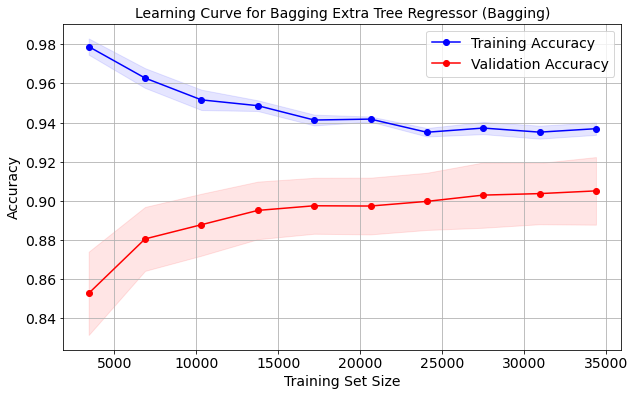

In [53]:
from sklearn.model_selection import learning_curve

# Generate learning curves for bag_reg_boost
train_sizes, train_scores, val_scores = learning_curve(
    bag_reg_boost, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker='o')
plt.plot(train_sizes, val_mean, label="Validation Accuracy", color="red", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="red", alpha=0.1)
plt.xlabel("Training Set Size", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Learning Curve for Bagging Extra Tree Regressor (Bagging)", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

#Save the figure
plt.savefig(PNG + 'learning_curve_intensity_model.png', dpi=300, bbox_inches='tight')

plt.show()


### Learning Curve Results

The learning curve results provide insights into the model's performance as the training set size increases. Here are the key observations:

- **Training Accuracy**: The training accuracy starts high and slightly decreases as the training set size increases. This is expected as the model is exposed to more data and learns to generalize better.

- **Validation Accuracy**: The validation accuracy starts lower than the training accuracy but increases steadily as the training set size increases. This indicates that the model's performance on unseen data improves with more training data.

- **Convergence**: Both training and validation accuracies converge as the training set size approaches the maximum. This suggests that the model is well-tuned and not overfitting.

- **Standard Deviation**: The shaded areas representing the standard deviation are relatively small, indicating consistent performance across different training sizes.

Overall, the learning curves show that the model performs well and generalizes effectively with increasing training data.


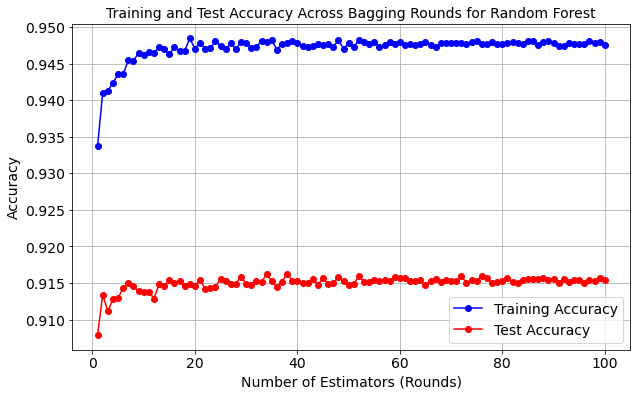

In [54]:

from sklearn.metrics import mean_squared_error, r2_score

# Initialize lists to store accuracies for each round
train_accuracies = []
test_accuracies = []
n_estimators = 100  # Number of bagging rounds to evaluate

# Loop over each round of bagging, increasing the number of estimators each time
for i in range(1, n_estimators + 1):
    # Define the Bagging Random Forest model with increasing number of estimators
    bag_reg_boost = BaggingRegressor(
        base_estimator=ExtraTreesRegressor(), n_estimators=i,  # n_estimators is the number of models to train
        max_samples=1000, bootstrap=False, # bootstrap is for bagging vs pasting
        n_jobs=-1, # number of CPU cores independently used for training and prediction. Use -1 for all available cores
    )
    
    # Fit the model on the training data
    bag_reg_boost.fit(X_train, y_train)
    
    # Calculate R^2 score for training and test sets
    train_accuracy = r2_score(y_train, bag_reg_boost.predict(X_train))
    test_accuracy = r2_score(y_test, bag_reg_boost.predict(X_test))
    
    # Store the accuracies
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot Training and Test Accuracy Across Training Rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators + 1), train_accuracies, label="Training Accuracy", marker='o', color="blue")
plt.plot(range(1, n_estimators + 1), test_accuracies, label="Test Accuracy", marker='o', color="red")
plt.xlabel("Number of Estimators (Rounds)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Training and Test Accuracy Across Bagging Rounds for Random Forest", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

#Save the figure
plt.savefig(PNG + 'training_and_test_accuracy_across_bagging_rounds_intensity_model.png', dpi=300, bbox_inches='tight')

plt.show()


### Summary of Plot Results

The plot above visualizes the training and test accuracies across different bagging rounds for the Random Forest model. Here are the key observations:

- **Training Accuracy**: The training accuracy starts high and remains consistently high across all bagging rounds. This indicates that the model fits the training data well.

- **Test Accuracy**: The test accuracy is slightly lower than the training accuracy but remains relatively stable across the bagging rounds. This suggests that the model generalizes well to unseen data.

- **Convergence**: Both training and test accuracies converge as the number of bagging rounds increases, indicating that the model's performance stabilizes with more estimators.

- **Overfitting**: The small difference between training and test accuracies suggests that the model is not overfitting significantly.

Overall, the results indicate that the Bagging Random Forest model performs well on both training and test datasets, with stable and high accuracies across different bagging rounds.


# Track Model

In [12]:
df_tracks = df_SHIPS_24_common_clean.copy()
df_tracks.head()

,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times
Code,,,,,,,,,,,
AL011982,1982-06-02 12:00:00,0.0,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,1982-06-02 12:00:00
AL011982,1982-06-02 12:00:00,6.0,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,1982-06-02 18:00:00
AL011982,1982-06-02 12:00:00,12.0,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,1982-06-03 00:00:00
AL011982,1982-06-02 12:00:00,18.0,22.8,85.0,20.57776,1001.0,27.2,59.0,18.622873,5.375940,1982-06-03 06:00:00
AL011982,1982-06-02 12:00:00,24.0,23.2,84.2,25.72220,995.0,26.7,53.0,17.491096,4.156708,1982-06-03 12:00:00


## Encoding Code

Each storm is assigned a code based on the basin where it occurs, name and year when it happened. The code is represented as a string

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


df_tracks_clean = df_tracks.reset_index()
df_tracks_clean['Code'] = LabelEncoder().fit(df_tracks_clean['Code']).transform(df_tracks_clean['Code']) # Extract the TC_codes
df_tracks_clean.head()

,Code,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times
0,0,1982-06-02 12:00:00,0.0,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,1982-06-02 12:00:00
1,0,1982-06-02 12:00:00,6.0,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,1982-06-02 18:00:00
2,0,1982-06-02 12:00:00,12.0,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,1982-06-03 00:00:00
3,0,1982-06-02 12:00:00,18.0,22.8,85.0,20.57776,1001.0,27.2,59.0,18.622873,5.375940,1982-06-03 06:00:00
4,0,1982-06-02 12:00:00,24.0,23.2,84.2,25.72220,995.0,26.7,53.0,17.491096,4.156708,1982-06-03 12:00:00


## Adding storm direction to the dataframe

In [55]:
# Merge df_tracks_clean with df_BT_24_common on the respective times
df_tracks_clean = pd.merge(df_tracks_clean, df_BT_24_common[['ISO_TIME', 'STORM_DIR']], left_on='New_Times', right_on='ISO_TIME', how='left')

# Rename the STORM_DIR column to Storm_Dir
df_tracks_clean.rename(columns={'STORM_DIR': 'Storm_Dir'}, inplace=True)

# Drop the ISO_TIME column as it is no longer needed
df_tracks_clean.drop(columns=['ISO_TIME'], inplace=True)

# Display the updated dataframe
df_tracks_clean.tail()

,Code,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times,Storm_Dir
0,0,1982-06-02 12:00:00,0.0,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,1982-06-02 12:00:00,47.0
1,0,1982-06-02 12:00:00,6.0,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,1982-06-02 18:00:00,52.0
2,0,1982-06-02 12:00:00,12.0,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,1982-06-03 00:00:00,68.0
3,0,1982-06-02 12:00:00,18.0,22.8,85.0,20.57776,1001.0,27.2,59.0,18.622873,5.375940,1982-06-03 06:00:00,71.0
4,0,1982-06-02 12:00:00,24.0,23.2,84.2,25.72220,995.0,26.7,53.0,17.491096,4.156708,1982-06-03 12:00:00,47.0


### Removing nans

In [59]:
df_tracks_clean = df_tracks_clean.dropna()
df_tracks_clean.shape

(55406, 13)

## Splitting the Data into Training and Test

We perform this split in a manner which maintains the codes across each both data sets

In [60]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets while ensuring the 'Code' column is consistent across the split
train_codes, test_codes = train_test_split(df_tracks_clean['Code'].unique(), test_size=0.2, random_state=42)

# Create training and test sets based on the split codes
train_df = df_tracks_clean[df_tracks_clean['Code'].isin(train_codes)]
test_df = df_tracks_clean[df_tracks_clean['Code'].isin(test_codes)]

# Print the shapes of the resulting DataFrames
print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")

train_df shape: (42951, 13)
test_df shape: (12455, 13)


In [20]:
train_df.head()

,Code,Original_Times,Times,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times
87,59,1982-08-28 12:00:00,0.0,13.7,22.2,15.43332,1008.0,26.6,75.0,11.420657,4.521963,1982-08-28 12:00:00
88,59,1982-08-28 12:00:00,6.0,13.9,22.7,18.00554,1006.0,26.8,76.0,10.957657,4.203007,1982-08-28 18:00:00
89,59,1982-08-28 12:00:00,12.0,14.1,23.6,18.00554,1005.0,27.9,75.0,10.854768,4.007519,1982-08-29 00:00:00
90,59,1982-08-28 12:00:00,18.0,14.5,24.9,20.57776,1003.0,26.4,74.0,11.060546,3.950930,1982-08-29 06:00:00
91,59,1982-08-28 12:00:00,24.0,14.9,26.3,23.14998,1002.0,26.0,72.0,9.620103,3.333597,1982-08-29 12:00:00


### Specifying Data which the Model should use

In [61]:
#Train data
X_train = np.array(train_df.drop(columns=['Vmax', 'Original_Times', 'New_Times', 'MSLP', 'Latitude', 'Longitude'])).astype(float)
lon_train = -1 * np.array(train_df['Longitude']).astype(float)
lat_train = np.array(train_df['Latitude']).astype(float)
y_train = np.column_stack((lat_train, lon_train))

#Test data
X_test = np.array(test_df.drop(columns=['Vmax', 'Original_Times', 'New_Times', 'MSLP', 'Latitude', 'Longitude'])).astype(float)
lon_test = -1 * np.array(test_df['Longitude']).astype(float)
lat_test = np.array(test_df['Latitude']).astype(float)
y_test = np.column_stack((lat_test, lon_test))

### Visualizing the Training and Test Data

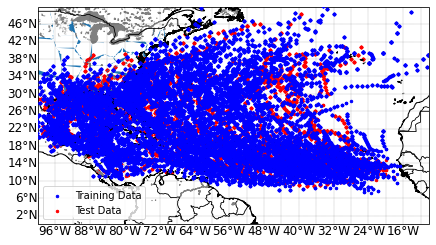

In [71]:
from helpers import *
# Set the projection
crs = ccrs.PlateCarree()

#Track Domain
min_lat_track = 0
max_lat_track = 50
min_lon_track = -100
max_lon_track = -10

#Set Plot Area
plot_area_track = [max_lon_track + 360.0, min_lon_track + 360.0, min_lat_track,max_lat_track]

gridsize = (1, 1)
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1, projection=crs)

ax1.scatter(y_train[:,1],y_train[:,0],marker="o",s=6,c="blue", zorder=100)
ax1.scatter(y_test[:,1],y_test[:,0],marker="o",s=6,c="red")

Cartopy_Features(ax1, 12, plot_area_track, 4, 4, 'k')

ax1.legend(['Training Data', 'Test Data'], loc='lower left')


plt.show()

## Training and Testing the Model

In [103]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Initialize the model with the best parameters found earlier
best_params_et = {
	'n_estimators': 100,
	'max_features': 'auto',
	'max_depth': None,
	'min_samples_split': 2,
	'min_samples_leaf': 1
}
best_regr = ExtraTreesRegressor(**best_params_et)

# Train the model with the training data
best_regr.fit(X_train, y_train)

# Predict and evaluate on the training data
y_train_pred = best_regr.predict(X_train)
y_test_pred = best_regr.predict(X_test)

# Print the evaluation metrics
print('Training set: Coefficient of determination (R^2): ', best_regr.score(X_train, y_train))
print('MSE (mean square error) on training set: %.2f' % mean_squared_error(y_train, y_train_pred))
print('Coefficient of determination on training set: %.2f' % r2_score(y_train, y_train_pred))

print('Test set: Coefficient of determination (R^2): ', best_regr.score(X_test, y_test))
print('MSE (mean square error) on test set: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Coefficient of determination on test set: %.2f' % r2_score(y_test, y_test_pred))

/home/disk/orca/adaley17/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Training set: Coefficient of determination (R^2):  1.0
MSE (mean square error) on training set: 0.00
Coefficient of determination on training set: 1.00
Test set: Coefficient of determination (R^2):  0.45334257525455124
MSE (mean square error) on test set: 124.75
Coefficient of determination on test set: 0.45


### Visualize the Results

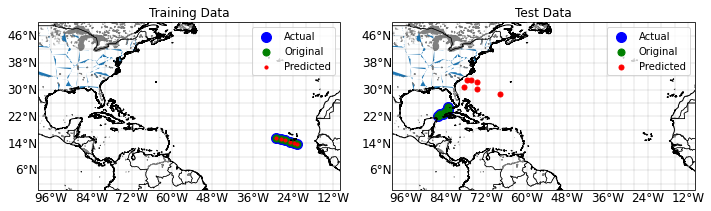

In [104]:
from helpers import *
# Set the projection
crs = ccrs.PlateCarree()

#Track Domain
min_lat_track = 0
max_lat_track = 50
min_lon_track = -100
max_lon_track = -10

#Set Plot Area
plot_area_track = [max_lon_track + 360.0, min_lon_track + 360.0, min_lat_track,max_lat_track]

gridsize = (1, 2)
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1, projection=crs)

# First subplot for training data
ax1.scatter(y_train[6:12][:,1], y_train[6:12][:,0], color='blue', s=100, label='Actual')
ax1.scatter(-1 * train_df['Longitude'][6:12], train_df['Latitude'][6:12], color='green', s=50, label='Original')
ax1.scatter(y_train_pred[6:12][:,1], y_train_pred[6:12][:,0], color='red', s=10, label='Predicted')
ax1.set_title('Training Data')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
Cartopy_Features(ax1, 12, plot_area_track, 4, 4, 'k')
ax1.legend(loc='best')

ax2 = plt.subplot2grid(gridsize, (0,1), colspan=1, rowspan=1, projection=crs)
# Second subplot for test data
ax2.scatter(y_test[6:12][:,1], y_test[6:12][:,0], color='blue', s=100, label='Actual')
ax2.scatter(-1 * test_df['Longitude'][6:12], test_df['Latitude'][6:12], color='green', s=50, label='Original')
ax2.scatter(y_test_pred[6:12][:,1], y_test_pred[6:12][:,0], color='red', s=25, label='Predicted')
ax2.set_title('Test Data')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
Cartopy_Features(ax2, 12, plot_area_track, 4, 4, 'k')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

### Cross Validation

In [105]:
from sklearn.model_selection import cross_val_score

# Use cross-validation to evaluate the model's performance
cv_scores = cross_val_score(best_regr, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Print the cross-validation scores
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())

Cross-validation scores:  [0.52269627 0.51493065 0.49529498 0.49962704 0.49550516]
Mean cross-validation score:  0.5056108199902162


### Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

# Define the best parameters for ExtraTreesRegressor
best_params_et = {
    'n_estimators': 100,
    'max_features': 'auto',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

bag_reg_boost = BaggingRegressor(
    base_estimator=ExtraTreesRegressor(**best_params_et), n_estimators=100,  # n_estimators is the number of models to train
    max_samples=1000, bootstrap=True, # bootstrap is for bagging vs pasting
    n_jobs=-1, # number of CPU cores independently used for training and prediction. Use -1 for all available cores
    )
bag_reg_boost.fit(X_train, y_train)
scores_bagg = cross_val_score(bag_reg_boost, X_train, y_train, cv=5)
print('mean accuracy', scores_bagg.mean())

mean accuracy 0.5218010311308812


### Pasting

In [109]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

# Define the best parameters for ExtraTreesRegressor
best_params_et = {
    'n_estimators': 100,
    'max_features': 'auto',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

bag_reg_past = BaggingRegressor(
    base_estimator=ExtraTreesRegressor(**best_params_et), n_estimators=100,  # n_estimators is the number of models to train
    max_samples=1000, bootstrap=False, # bootstrap is for bagging vs pasting
    n_jobs=-1, # number of CPU cores independently used for training and prediction. Use -1 for all available cores
    )
bag_reg_past.fit(X_train, y_train)
scores_past = cross_val_score(bag_reg_boost, X_train, y_train, cv=5)
print('mean accuracy', scores_past.mean())

mean accuracy 0.5226969719729075


### Evaluating Learning Curves


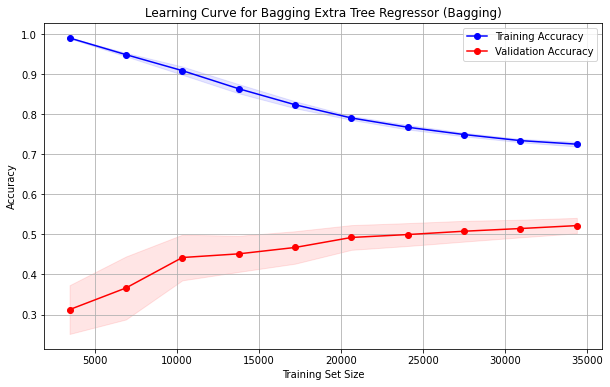

In [110]:
from sklearn.model_selection import learning_curve

# Generate learning curves for bag_reg_boost
train_sizes, train_scores, val_scores = learning_curve(
    bag_reg_boost, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker='o')
plt.plot(train_sizes, val_mean, label="Validation Accuracy", color="red", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="red", alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Bagging Extra Tree Regressor (Bagging)")
plt.legend(loc="best")
plt.grid()
plt.show()

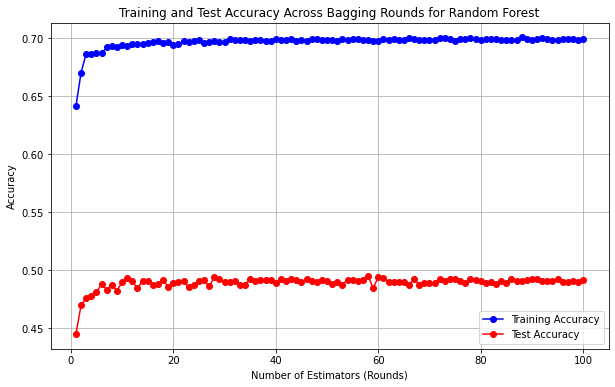

In [111]:

from sklearn.metrics import mean_squared_error, r2_score

# Initialize lists to store accuracies for each round
train_accuracies = []
test_accuracies = []
n_estimators = 100  # Number of bagging rounds to evaluate

# Loop over each round of bagging, increasing the number of estimators each time
for i in range(1, n_estimators + 1):
    # Define the Bagging Random Forest model with increasing number of estimators
    bag_reg_boost = BaggingRegressor(
        base_estimator=ExtraTreesRegressor(), n_estimators=i,  # n_estimators is the number of models to train
        max_samples=1000, bootstrap=False, # bootstrap is for bagging vs pasting
        n_jobs=-1, # number of CPU cores independently used for training and prediction. Use -1 for all available cores
    )
    
    # Fit the model on the training data
    bag_reg_boost.fit(X_train, y_train)
    
    # Calculate R^2 score for training and test sets
    train_accuracy = r2_score(y_train, bag_reg_boost.predict(X_train))
    test_accuracy = r2_score(y_test, bag_reg_boost.predict(X_test))
    
    # Store the accuracies
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot Training and Test Accuracy Across Training Rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators + 1), train_accuracies, label="Training Accuracy", marker='o', color="blue")
plt.plot(range(1, n_estimators + 1), test_accuracies, label="Test Accuracy", marker='o', color="red")
plt.xlabel("Number of Estimators (Rounds)")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy Across Bagging Rounds for Random Forest")
plt.legend(loc="best")
plt.grid()
plt.show()

## Trying to improve the model

### Creating a Polynomial Feature

In [89]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Create a pipeline with polynomial features and ExtraTreesRegressor
pipeline = Pipeline([
	('poly', poly),
	('regr', ExtraTreesRegressor())
])

# Define the parameter grid for RandomizedSearchCV
param_grid = {
	'regr__n_estimators': [50, 100, 200],
	'regr__max_features': ['auto', 'sqrt', 'log2'],
	'regr__max_depth': [None, 10, 20, 30],
	'regr__min_samples_split': [2, 5, 10],
	'regr__min_samples_leaf': [1, 2, 4]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1, scoring='r2', random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
best_model = random_search.best_estimator_

# Predict and evaluate
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('Training set: Coefficient of determination (R^2): ', best_model.score(X_train, y_train))
print('MSE (mean square error) on training set: %.2f' % mean_squared_error(y_train, y_train_pred))
print('Coefficient of determination on training set: %.2f' % r2_score(y_train, y_train_pred))

print('Test set: Coefficient of determination (R^2): ', best_model.score(X_test, y_test))
print('MSE (mean square error) on test set: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Coefficient of determination on test set: %.2f' % r2_score(y_test, y_test_pred))

/home/disk/orca/adaley17/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters found:  {'regr__n_estimators': 200, 'regr__min_samples_split': 2, 'regr__min_samples_leaf': 4, 'regr__max_features': 'auto', 'regr__max_depth': 10}
Training set: Coefficient of determination (R^2):  0.7314570417097777
MSE (mean square error) on training set: 58.59
Coefficient of determination on training set: 0.73
Test set: Coefficient of determination (R^2):  0.49235443818669045
MSE (mean square error) on test set: 117.52
Coefficient of determination on test set: 0.49


### Visualize the results

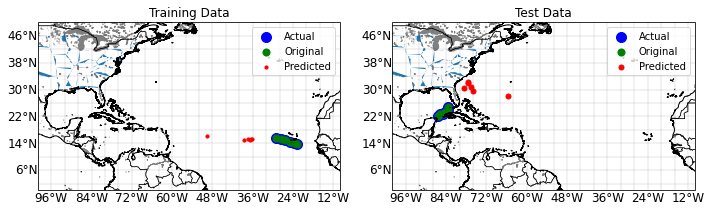

In [90]:
from helpers import *
# Set the projection
crs = ccrs.PlateCarree()

#Track Domain
min_lat_track = 0
max_lat_track = 50
min_lon_track = -100
max_lon_track = -10

#Set Plot Area
plot_area_track = [max_lon_track + 360.0, min_lon_track + 360.0, min_lat_track,max_lat_track]

gridsize = (1, 2)
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1, projection=crs)

# First subplot for training data
ax1.scatter(y_train[6:12][:,1], y_train[6:12][:,0], color='blue', s=100, label='Actual')
ax1.scatter(-1 * train_df['Longitude'][6:12], train_df['Latitude'][6:12], color='green', s=50, label='Original')
ax1.scatter(y_train_pred[6:12][:,1], y_train_pred[6:12][:,0], color='red', s=10, label='Predicted')
ax1.set_title('Training Data')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
Cartopy_Features(ax1, 12, plot_area_track, 4, 4, 'k')
ax1.legend(loc='best')

ax2 = plt.subplot2grid(gridsize, (0,1), colspan=1, rowspan=1, projection=crs)
# Second subplot for test data
ax2.scatter(y_test[6:12][:,1], y_test[6:12][:,0], color='blue', s=100, label='Actual')
ax2.scatter(-1 * test_df['Longitude'][6:12], test_df['Latitude'][6:12], color='green', s=50, label='Original')
ax2.scatter(y_test_pred[6:12][:,1], y_test_pred[6:12][:,0], color='red', s=25, label='Predicted')
ax2.set_title('Test Data')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
Cartopy_Features(ax2, 12, plot_area_track, 4, 4, 'k')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

In [97]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor

# Define the base models
base_models = [
    ('et', ExtraTreesRegressor(**best_params_et)),
    ('svr', SVR(kernel='rbf', C=100, gamma=0.1))
]

# Define the meta-model
meta_model = RidgeCV()

# Create the stacking regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

# Use only the latitude values as the target variable
y_train_lat = y_train[:, 0]
y_test_lat = y_test[:, 0]

# Train the stacking regressor with the training data
stacking_regressor.fit(X_train, y_train_lat)

# Predict and evaluate on the training data
y_train_pred = stacking_regressor.predict(X_train)
y_test_pred = stacking_regressor.predict(X_test)

# Print the evaluation metrics
print('Training set: Coefficient of determination (R^2): ', stacking_regressor.score(X_train, y_train_lat))
print('MSE (mean square error) on training set: %.2f' % mean_squared_error(y_train_lat, y_train_pred))
print('Coefficient of determination on training set: %.2f' % r2_score(y_train_lat, y_train_pred))

print('Test set: Coefficient of determination (R^2): ', stacking_regressor.score(X_test, y_test_lat))
print('MSE (mean square error) on test set: %.2f' % mean_squared_error(y_test_lat, y_test_pred))
print('Coefficient of determination on test set: %.2f' % r2_score(y_test_lat, y_test_pred))

KeyboardInterrupt: 

## Cross Validation

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

bag_reg_pass = BaggingRegressor(
    base_estimator=ExtraTreesRegressor(), n_estimators=100,  # n_estimators is the number of models to train
    max_samples=1000, bootstrap=False, # bootstrap is for bagging vs pasting
    n_jobs=-1, # number of CPU cores independently used for training and prediction. Use -1 for all available cores
    )
scores = cross_val_score(bag_reg_pass, data, y, cv=5)
print('mean accuracy', scores.mean())

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler()
scaler.fit_transform(track_data)# fit the model for data normalization
newdata = scaler.transform(track_data) # transform the data. watch that data was converted to a numpy array

# Split data into 50% train and 50% test subsets
print(f"There are {track_data.shape[0]} data samples")


There are 70895 data samples
train_df shape: (56985, 12)
test_df shape: (13910, 12)
